# Transition risk and climate risk 

> This project aims at jointly modeling physical and
transition risk within a Merton-like credit risk model, building up on [Bouchet and Le Guenedal, 2020].

<br>

**Target** : Introduce physical risk in the model as a Poisson component variable, whose
jumps are proportional to the total asset value (any alternative may be proposed). You
may consider a simpler model where physical risk occurs only once (with a exponential
law time distribution).

* Assess the additional impact of physical risk on default probabilities

## Merton Model

Il est nécessaire d'initialiser notre modèle avec la valeur de la firme en année 0 : 

*Pour cela on récupère* :

* PD : Probabilité de défault -> Permet de déterminer N1 et N2 
* $\sigma_v$ : Déterminé grâce au cours de l'action 
* V,E,D : récupérés grâce à l'étude des comptes

In [1]:
import numpy as np 
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

## Merton's Inputs

In [2]:
V = 10000 # Asset value 
E = 5000 # Equity value 
D = V-E #Debt value
T = 15 # Maturity - Horizon 2020 - 2035

## Déterminer $\sigma_v$

> On peut déterminer $\sigma_v$ grâce à une étude de la volatilité de l'action :

```python
# Slice results for past year (252 trading days)
v_a_per = results[t-252:t,i]

# Calculate log returns
v_a_ret = np.log(v_a_per/np.roll(v_a_per,1))
v_a_ret[0] = np.nan

# Calculate new asset volatility
sigma_a = np.nanstd(v_a_ret)
```



### Pour faciliter on fixe $\sigma_v$

In [3]:
sigma_v = 0.2 # 20 %

## Passer de PD à d1 et d2

On détermine tout d'abord $d_1$ :

En année 0 : 

$d_1 = \frac{ ln(\frac{V}{D})+ (r +\frac{1}{2}\sigma_v^2)\times T}{\sigma_v\sqrt{T}}$

$DD = d_1 $

$PD = \Phi(-DD)$

Avec $\Phi$ = N : Cumulated normal distribution

In [4]:
PD = 0.2 # 2% of PD

## Reverse cumulative normal distribution

In [5]:
inv_PD = norm.cdf(PD) # Inverse of cumulative normal distribution -- cumulative : norm.ppdf

In [6]:
inv_PD

0.579259709439103

## Compute d1 - using PD and $\sigma_v$

$PD = \Phi(-DD) \rightarrow d_1 = -\Phi^{-1}(PD)$

In [7]:
d1 = -inv_PD

In [8]:
d2 = d1-sigma_v*np.sqrt(T)

In [9]:
print('d1 =',round(d1,3))
print('d2 =',round(d2,3))

d1 = -0.579
d2 = -1.354


# Introduce carbon tax

3 évolutions de prix possibles - sur l'horizon 2030-2035 (si plus changer maturité)

In [10]:
scenarios = pd.read_excel('scenarios_edited.xlsx')
scenarios = scenarios.set_index('Year')

scenarios.head()

,SSP2-Baseline (3.8°C)-Cout Carbone (US$2010/tCO2),SSP2-Baseline (3.8°C)-Temps de retour températures extrêmes (années),SSP2-Baseline (3.8°C)-Augmentation intensité températures extrêmes,SSP2-34 (2.2°C)-Cout Carbone (US$2010/tCO2),SSP2-34 (2.2°C)-Temps de retour températures extrêmes (années),SSP2-34 (2.2°C)-Augmentation intensité températures extrêmes,SSP2-26 (1.8°C)-Cout Carbone (US$2010/tCO2),SSP2-26 (1.8°C)-Temps de retour températures extrêmes (années),SSP2-26 (1.8°C)-Augmentation intensité températures extrêmes
Year,,,,,,,,,
2021,0,20,0.00,7,20,0.00,7,20,0
2030,0,15,0.02,85,15,0.01,390,17,0
2040,0,10,0.04,135,10,0.02,640,14,0
2050,0,5,0.06,240,5,0.03,1124,11,0
2060,0,2,0.08,390,2,0.04,1850,8,0


### Extract carbon prices 

In [11]:
carbon_cols = scenarios.columns[scenarios.columns.str.contains('Carbone')]
carbon_prices = scenarios[carbon_cols]

### Create array with linspace

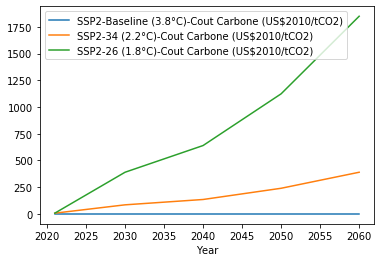

In [12]:
c_prices = {}
for col in carbon_cols :
    tmp = [] # temporary list to store carbon prices
    for i , (year,price) in enumerate(zip(carbon_prices.index,carbon_prices[col])):
        if i < len(carbon_prices.index)-1:
            if i==0:
                tmp+=np.linspace(price,carbon_prices[col].values[i+1],carbon_prices.index[i+1]-year+1).tolist()
            else :
                tmp+=np.linspace(price,carbon_prices[col].values[i+1],carbon_prices.index[i+1]-year+1).tolist()[1:]
    c_prices[col] = tmp
carbon_df = pd.DataFrame(c_prices)
carbon_df.index += 2021
carbon_df = carbon_df.rename_axis("Year")

# Created df with carbon price evolution (linear between gap prices)
carbon_df.plot()

# Transition risk  - From carbon tax to asset devaluation

### Need to compute carbon footprint each year : 

* Sum of carbon footprint on each country of activity : i = 0; one company only

$CC(k,t) = \sum_{j\in M} Scope_1(j,t)\times CP(j,k,t) $

k is scenario chosen ; j a region ; t is time

* To simplify our study - Only consider one country ? 

### Shock to EBITDA 

* Firm is equal to a given multiplier times EBITDA 

$\zeta(k,t) = \frac{CC(k,t)}{EBITDA(k=0,t=0)}$

### Link with initial firm value 

$V(k,t) = (1-\zeta(k,t))\times V(k=0,t=0) $

## What amount of carbon dioxyde ? British Petroleum

<img src = https://safety4sea.com/wp-content/uploads/2019/02/bp-co2-in-2040-1024x517.png style="width:400px;"/>

In [13]:
### Create scenario
def create_scenarios(carbon_dict,T):
    ## Create a scenario based on dict : {initial_value1:[growth],initial_value2:[growth]}
    carbon_scenarios = [] # Stores all carbon scenario 
    for (i,base_value) in enumerate(carbon_dict):
        for (j,growth_rate) in enumerate(carbon_dict[base_value]):
            scenario = [base_value*(1+growth_rate)**t for t in range(T)]
            carbon_scenarios.append(scenario)
    return(carbon_scenarios)

### Plot scenarios
def plot_scenarios(carbon_scenarios,T,prefix='Carbon tax',ylabel='Carbon tax [USD]'):
    time  = [i+2021 for i in range(T)]
    for (i,scenario) in enumerate(carbon_scenarios):
        plt.plot(time,scenario,label=f"{prefix} {i+1}")
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [14]:
bp_dict = {35:[0.01,-0.03,-0.079]}

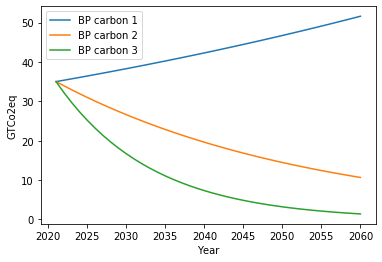

In [15]:
T = 40 # Set horizon
bp_carbon_scenarios = create_scenarios(bp_dict,T=40)
plot_scenarios(bp_carbon_scenarios,T=40,prefix='BP carbon',ylabel='GTCo2eq')

## Compute each carbon cost for each scenario

In [16]:
def carbon_cost(carbon_scenarios,firm_scenario):
    """Carbon scenarios : liste des prix du carbone sur la durée de temps considérée
       Firm scenario : Trajectoire de décarbonation envisagé par l'entreprise
       
    Output : array avec le coût de chaque possibilité"""
    results = {}
    for (i,carbon_tax) in enumerate(carbon_scenarios):
        ## Loop on each carbon tax & compute a price 
        for (j,scenario) in enumerate(firm_scenario):
            cost = []
            for (carbon_price,scope) in zip(carbon_tax,scenario):
                cost.append(carbon_price*scope)
            results[f'scenario_{i}_{j}'] = cost # scenario i (which carbon tax) ; j (which alignement scenario)
    return(results)

In [17]:
### Use carbon df & firm scenarios
# create array with carbon df
array_carbon_df = [carbon_df[col].tolist() for col in carbon_df.columns]
results = carbon_cost(array_carbon_df,bp_carbon_scenarios)

In [18]:
df = pd.DataFrame(results)
df.index = carbon_df.index

In [19]:
df.head(5)

,scenario_0_0,scenario_0_1,scenario_0_2,scenario_1_0,scenario_1_1,scenario_1_2,scenario_2_0,scenario_2_1,scenario_2_2
Year,,,,,,,,,
2021,0.0,0.0,0.0,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000
2022,0.0,0.0,0.0,553.816667,531.883333,505.015000,1751.788889,1682.411111,1597.423333
2023,0.0,0.0,0.0,868.785167,801.333167,722.418585,3288.689056,3033.357056,2734.634735
2024,0.0,0.0,0.0,1189.997655,1054.137315,902.320605,4856.152047,4301.732073,3682.197216
2025,0.0,0.0,0.0,1517.547515,1291.052015,1049.289491,6454.635429,5491.274569,4462.977970


##### Pour chaque scénario on calcule le coût de carbone associé

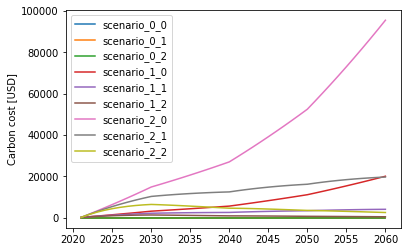

In [20]:
time  = [i+2021 for i in range(T)]
for col in df.columns:
    plt.plot(time,df[col],label=col)
plt.ylabel('Carbon cost [USD]')
plt.legend()
plt.show() # Carbon price

### Compute zeta & PD 

In [105]:
import math
def compute_pd(carbon_cost,V,D,multiple=6,T=1,PD0=0.02,sigma_v=0.5,r=0):
    # list of zeta, compute evolution of PD
    PD = [PD0]
    for i in range(1,len(carbon_cost)):
        zeta = carbon_cost[i]/(V/multiple)
        if zeta > 1 :
            #### Cannot handle carbon tax : 
            PD.append(1)
        # Compute pd ième 
        else:
            DD = ( np.log( (1-zeta)*V/D )+ (r+0.5*sigma_v**2)*T )/(sigma_v*np.sqrt(T))
#             if DD > -0.5 :
#                 # Pas de défaut possible
#                 pdi = PD0
#             elif math.isnan(norm.ppf(-DD)):
#                 pdi = 1
#             else :
#                 pdi = norm.ppf(-DD)
            pdi = norm.cdf(-DD)
            PD.append(pdi)             
    return(PD)

### Attention à choisir des valeurs pertinentes sinon pas de résultats

> Il apparaît que le modèle est hyper sensible et que un léger changement au niveau de V & D change drastiquement les valeurs

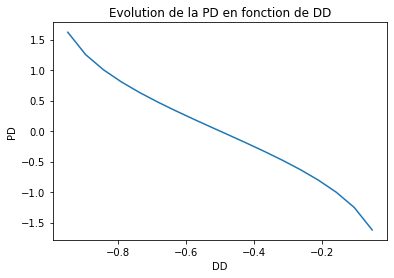

In [22]:
plt.xlabel('DD')
plt.ylabel("PD")
plt.plot(np.linspace(-1,0,20),norm.ppf(-np.linspace(-1,0,20)))
plt.title('Evolution de la PD en fonction de DD')
plt.show()

### Quelques visualisations

In [106]:
V = 8000
D = 2000

In [107]:
prob_defaults = []
time = df.index.tolist()
for (i,col) in enumerate(df.columns) : 
    prob_defaults.append(compute_pd(df.iloc[:,i].values,V,D,multiple=6,T=1,PD0=0.02,sigma_v=0.5,r=0))

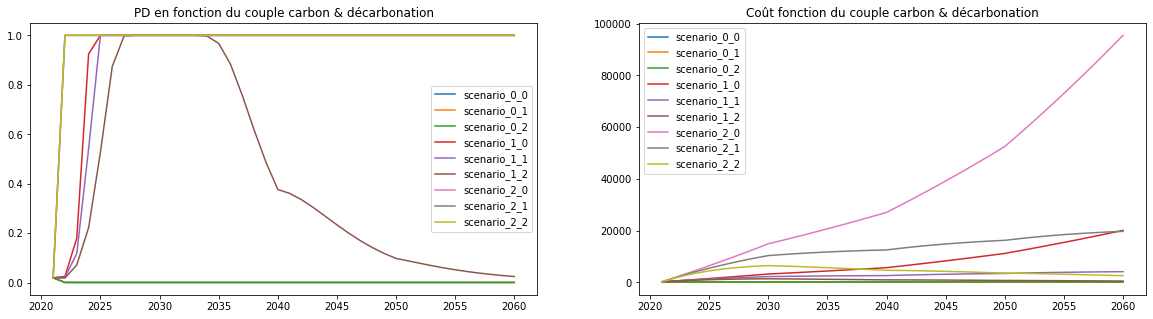

In [108]:
plt.figure(figsize=(20,5))
plt.subplot(121)
for i,pd_ar in enumerate(prob_defaults) :
    plt.plot(time,pd_ar,label=df.columns[i])
plt.legend()
plt.title("PD en fonction du couple carbon & décarbonation")
plt.subplot(122)
for col in df.columns:
    plt.plot(time,df[col],label = col)
plt.title("Coût fonction du couple carbon & décarbonation")
plt.legend()
plt.show()

## Physical risk


Sur l'horizon des 40 années, une catastrophe arrive 

* L'année t est choisie avec une loi de poisson ? ou random au bout 2035-2060.

#### Amplitude dépend du scénario de transition : 

* 20% de la valeur des actifs si prix carbon bas (BaU) (**edit**: modifié à 84% car sinon rien de probant)
* 10% de la valeur des assets si prix carbon medium
* 4% de la valeur des assets si prix carbon haut


In [26]:
np.random.randint(2035,2060)

2053

In [100]:
def compute_poisson_loss(V,scenario):
    # Calcul de la perte liée au risque physique
    year = np.random.randint(2035,2060)
    """Scenario 0 : BaU
       Scenario 1 : Medium
       Scenario 2 : Low """
    losses_dic = {0:0.84, 1:0.1, 2:0.04}
    loss_x = losses_dic[scenario]
    loss = np.random.poisson(V*loss_x,1)
    poisson_dict = {'year':year,'loss':loss[0]}
    """Return a dict to access easily to data"""
    return(poisson_dict)

In [101]:
compute_poisson_loss(V,0)

{'year': 2045, 'loss': 839834}

### Add physical risk to probability of default

In [102]:
import math
def compute_pd(carbon_cost,V,D,scenario = 0,physical =False,multiple=6,T=1,PD0=0.02,sigma_v=0.5,r=0):
    # list of zeta, compute evolution of PD
    PD = [PD0]
    if physical :
        ## Consider physical risk
        phys_dict = compute_poisson_loss(V,scenario)
        year_idx = phys_dict['year'] - 2021
        loss = phys_dict['loss']
    else :
        year_idx = len(carbon_cost)+10
    for i in range(1,len(carbon_cost)):
        if i == year_idx : # Année de l'accident
            V = V-loss
        zeta = carbon_cost[i]/(V/multiple)
        if zeta > 1 :
            #### Cannot handle carbon tax : 
            PD.append(1)
        # Compute pd ième 
        else:
            DD = ( np.log( (1-zeta)*V/D )+ (r+0.5*sigma_v**2)*T )/(sigma_v*np.sqrt(T))
#             if DD > -0.5 :
#                 # Pas de défaut possible
#                 pdi = PD0
#             elif math.isnan(norm.ppf(-DD)):
#                 pdi = 1
#             else :
#                 pdi = norm.ppf(-DD)
            pdi = norm.cdf(-DD)
            PD.append(pdi)             
    return(PD)

### Example with scenario 0

In [103]:
prob_defaults_phys = []
time = df.index.tolist()
for (i,col) in enumerate(df.columns) : 
    if i < 3:
        prob_defaults_phys.append(compute_pd(df.iloc[:,i].values,V,D,scenario =0,physical=True,multiple=6,T=1,PD0=0.02,sigma_v=0.5,r=0))

In [96]:
# Gabriel
def compute_poisson_loss(V,scenario):
    # Calcul de la perte liée au risque physique
    """Scenario 0 : BaU
       Scenario 1 : Medium
       Scenario 2 : Low """
    Temps=40 # 40 anées
    Freq0={0:1/15, 1:1/10, 2:1/5, 3:1/2}
    Freq1={0:1/15, 1:1/10, 2:1/5, 3:1/2}
    Freq2={0:1/17, 1:1/14, 2:1/11, 3:1/8}
    
    AmplitudePerte= {0:0.12, 1:0.08, 2:0.04}##correspond au 1-zeta, zeta =PertePhysique/ebtitda    
    Frequence={0:Freq0, 1:Freq1, 2:Freq2}
    f=Frequence[scenario]

    N=10
  
    #xk est une liste de 10 éléments, 10 pour 10 ans etk l'intervalle x2 c'est de 2030 à 2040,
    #Chaque élément de la liste correpond au nombre de secheresse par an 
    x0=np.random.poisson(f[0],N)
    x1=np.random.poisson(f[1],N)
    x2=np.random.poisson(f[2],N)
    x3=np.random.poisson(f[3],N)
    # concatenate array
    p0 = np.concatenate((x0, x1))
    p1 = np.concatenate((x2,x3))
    x = np.concatenate((p0,p1))
    print(x)
    loss=np.zeros(Temps)

    for i in range(len(x))
    #Calcul une liste avec les différents V en fonction du temps 
    for k in range(N):
        loss[k+1]=-x0[k]*AmplitudePerte[scenario]*V
        ##Ci dessus le calcul de la perte un pourcentage de V, fois le nombre de secheresse

    for k in range(N-1):
        loss[k+1+N]=-x1[k]*AmplitudePerte[scenario]*V


    for k in range(N-1):
        loss[k+1+2*N]=-x2[k]*AmplitudePerte[scenario]*V

    for k in range(N-1):
        loss[k+1+3*N]=-x3[k]*AmplitudePerte[scenario]*V
      
  
    poisson_dict = loss
    """Return a dict to access easily to data"""
    return(poisson_dict)

In [97]:
#Scénario
V=1e6;
scenario=0;
VApresSecheresse=compute_poisson_loss(V,scenario)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 2 1 0
 0 1 1]
[0 0 0 0 2 1 0 0 1 1]


In [77]:
VApresSecheresse

array([      0.,       0.,       0.,       0., -120000.,       0.,
             0.,       0.,       0.,       0.,       0.,       0.,
             0.,       0.,       0.,       0., -120000.,       0.,
       -120000.,       0.,       0.,       0.,       0.,       0.,
             0.,       0.,       0.,       0.,       0.,       0.,
             0., -240000., -120000.,       0.,       0.,       0.,
             0.,       0.,       0.,       0.])

In [66]:
len(df.iloc[:,0].values)

40

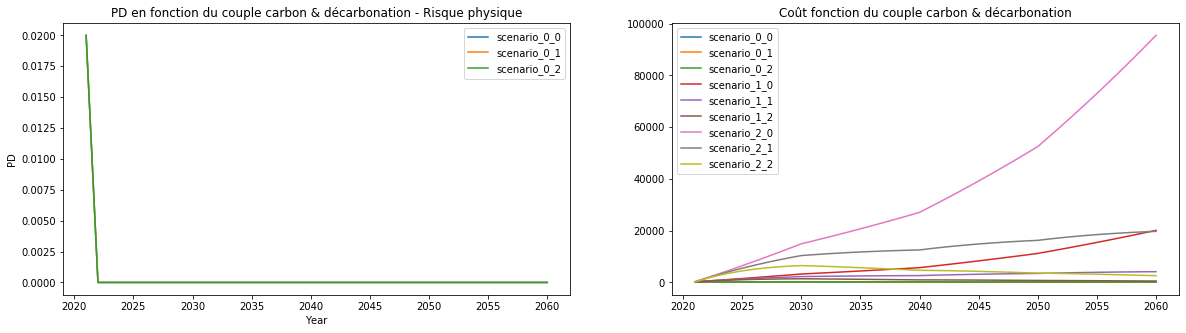

In [104]:
## quelques plots
plt.figure(figsize=(20,5))
plt.subplot(121)
for i,pd_ar in enumerate(prob_defaults_phys) :
    plt.plot(time,pd_ar,label=df.columns[i])
plt.legend()
plt.xlabel('Year')
plt.ylabel('PD')
plt.title("PD en fonction du couple carbon & décarbonation - Risque physique")
plt.subplot(122)
for col in df.columns:
    plt.plot(time,df[col],label = col)
plt.title("Coût fonction du couple carbon & décarbonation")
plt.ylabel('')
plt.legend()
plt.show()